# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [51]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [52]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Run the pipeline

In [53]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, warnings=False, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

In [54]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9698
Test evaluation --> roc_auc: 0.8684
Time elapsed: 0.281s
-------------------------------------------------
Total time: 0.281s


Final results ==================== >>
Duration: 0.281s
-------------------------------------
LightGBM --> roc_auc: 0.8684


## Deep Feature Synthesis

In [55]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created.


In [56]:
# Create 50 new features using DFS
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Creating new features...
 --> 73 new features were added to the dataset.


In [57]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

LOG(RainToday_other)    8837
LOG(Sunshine)            141
dtype: int64

In [58]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 8837 missing values using the KNN imputer in feature LOG(RainToday_other).
 --> Imputing 141 missing values using the KNN imputer in feature LOG(Sunshine).


In [59]:
# 50 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number
atom.feature_selection(
    strategy="RFECV",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.07228915662650602 repeated in 505378.0% of the rows.
 --> Feature LOG(RainToday_other) was removed due to low variance. Value 0.0 repeated in 505378.0% of the rows.
 --> Feature Cloud3pm + RainToday_other was removed due to collinearity with another feature.
 --> Feature Cloud3pm - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Evaporation + RainToday_other was removed due to collinearity with another feature.
 --> Feature Humidity3pm + WindDir3pm was removed due to collinearity with another feature.
 --> Feature Humidity3pm - RainToday_other was removed due to collinearity with another feature.
 --> Feature Humidity9am + RainToday_No was removed due to collinearity with another feature.
 --> Feature Humidity9am + WindGustDir was removed due to collinearity with another feature.
 --> Feature Humidity9am - WindDir3pm was removed due to

In [60]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + RainToday_other,Cloud3pm,0.99948
1,Cloud3pm - WindDir3pm,"Cloud3pm, Cloud3pm + RainToday_other","0.99972, 0.99918"
2,Evaporation + RainToday_other,Evaporation,0.99975
3,Humidity3pm + WindDir3pm,Humidity3pm,1.0
4,Humidity3pm - RainToday_other,"Humidity3pm, Humidity3pm + WindDir3pm","0.99999, 0.99999"
5,Humidity9am + RainToday_No,Humidity9am,0.99978
6,Humidity9am + WindGustDir,"Humidity9am, Humidity9am + RainToday_No","1.0, 0.99977"
7,Humidity9am - WindDir3pm,"Humidity9am, Humidity9am + RainToday_No, Humid...","1.0, 0.99978, 0.99999"
8,Humidity9am - WindGustDir,"Humidity9am, Humidity9am + RainToday_No, Humid...","1.0, 0.99978, 0.99999, 1.0"
9,Location + Pressure3pm,Pressure3pm,1.0


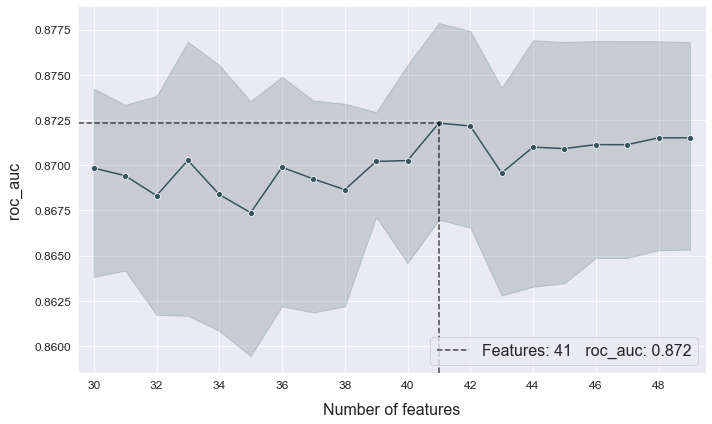

In [61]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [62]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9932
Test evaluation --> roc_auc: 0.867
Time elapsed: 0.547s
-------------------------------------------------
Total time: 0.547s


Final results ==================== >>
Duration: 0.547s
-------------------------------------
LightGBM --> roc_auc: 0.867


## Genetic Feature Generation

In [63]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created.


In [64]:
# Create new features using Genetic Programming
atom.feature_generation(
    strategy='GFG',
    n_features=20,
    generations=10,
    population=2000,
)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.13         0.130778        3          0.49782              N/A      9.57s
   1     3.31         0.324661        6         0.515497              N/A     10.25s
   2     3.79         0.412231       10         0.526287              N/A      8.13s
   3     4.53         0.462306       13         0.530089              N/A      6.70s
   4     5.96         0.486278       15         0.530094              N/A      6.25s
   5     5.36         0.489311       11         0.531058              N/A      4.79s
   6     6.63         0.488193       15         0.534876              N/A      3.52s
   7     8.58         0.495064        9         0.537901              N/A      2.28s
   8     7.74         0.502927        9        

In [65]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,feature 24,"mul(mul(add(RainToday_Yes, Cloud3pm), mul(Wind...",0.528901
1,feature 25,"mul(Humidity3pm, mul(add(RainToday_Yes, Cloud3...",0.528901
2,feature 26,"mul(mul(Cloud3pm, mul(WindGustSpeed, Humidity3...",0.524057


In [66]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9683
Test evaluation --> roc_auc: 0.8676
Time elapsed: 0.290s
-------------------------------------------------
Total time: 0.290s


Final results ==================== >>
Duration: 0.290s
-------------------------------------
LightGBM --> roc_auc: 0.8676


## Analyze results

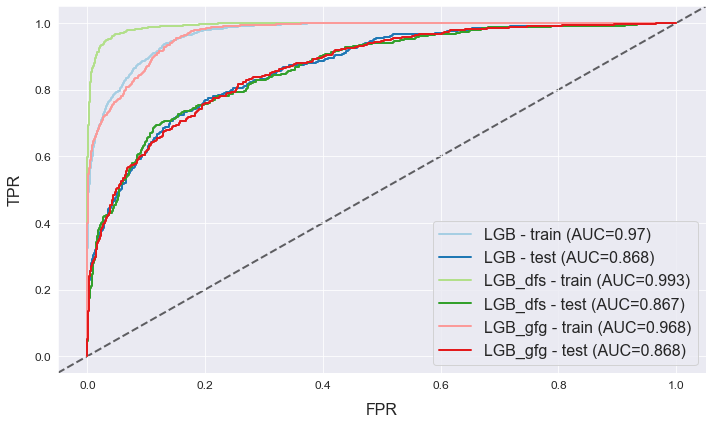

In [67]:
# Use atom's plots to compare the three models
atom.palette = "Paired"
atom.plot_roc(dataset="both")
atom.reset_aesthetics()

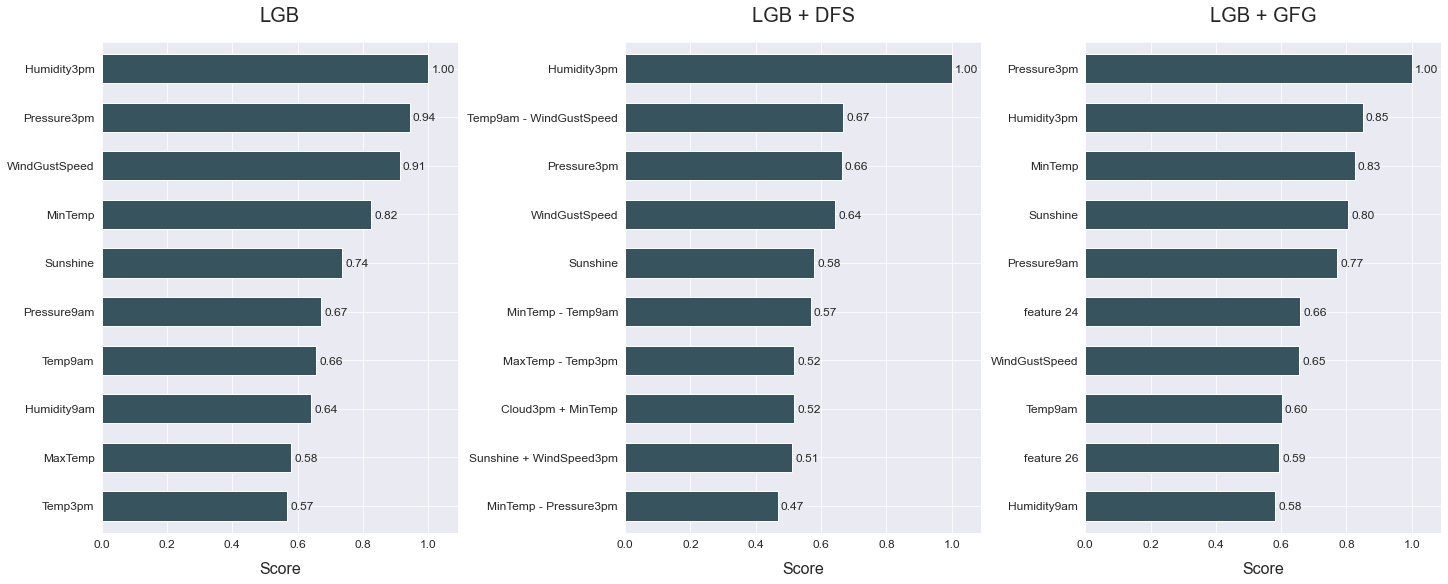

In [68]:
# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + DFS")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + GFG")

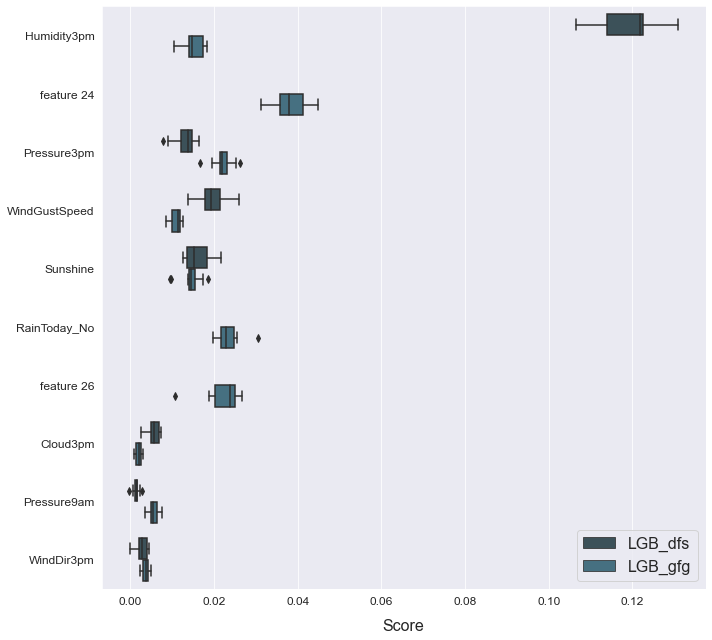

In [69]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_DFS", "LGB_GFG"], show=10)

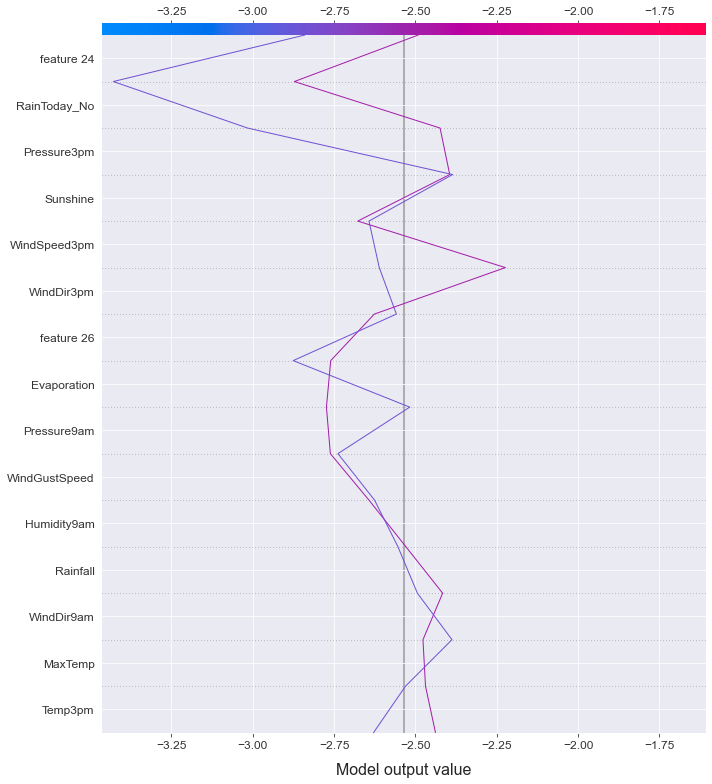

In [70]:
atom.LGB_gfg.decision_plot(index=(0, 10), show=15)